In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import style
plt.style.use('seaborn-v0_8')

In [2]:
datasets_map = {
    "red_team_chat": "Red Team",
    "full_chat":"Help/Harm",
    "xsum":"XSum",
}

methods_map = {
    "LttHB": "LTT",
    "RcpsWSR": "RCPS",
    'DKW': "DKW", 
    'DKWBonferroni': "DKW", 
    'OrderStats': "Order Stats", 
    'OrderStatsBonferroni': "Order Stats", 
    'KS': "QRC (KS)",
    'BJ': "QRC (BJ)",
    'One-sided-BJ': "QRC (1-BJ)",
    'Two-sided-BJ': "QRC (2-BJ)",
}

method_order = list(methods_map.keys())

In [110]:
def run_exp(
    dataset = "red_team_chat",
    loss_fn = "toxicity",
    measure = "Mean",
    beta_lo = 0.0,
    beta_hi = 1.0,
    no_data = 1000,
    grid_size = 100,
    single_prompt = False,
    alpha = 0.05
):
    if measure == "VaR-Int" or measure == "CVaR":
        exp_name = "{}_{}_beta_lo_{}_beta_hi_{}_no_data_{}_grid_size_{}_full_results".format(
            dataset, 
            loss_fn, 
            beta_lo,
            beta_hi,
            no_data, 
            grid_size
        )
        root = "../output/{}/{}.csv".format(
            dataset, 
            exp_name
        )
        bound_col = "guaranteed_auc"
        emp_col = "empirical_auc"

    elif measure == "VaR":
        exp_name = "{}_{}_var_beta_{}_no_data_{}".format(
            dataset, 
            loss_fn, 
            beta_lo,
            no_data, 
        )
        root = "../output/{}/{}.csv".format(
            dataset, 
            exp_name
        )
        bound_col = "quantile_alpha"
        emp_col = "quantile_loss"
        
    elif measure == "Mean":
        exp_name = "{}_{}_mean_no_data_{}_full_results".format(
            dataset, 
            loss_fn, 
            no_data, 
        )
        root = "../output/{}/{}.csv".format(
            dataset, 
            exp_name
        )
        bound_col = "alpha"
        emp_col = "mean loss"
    else:
        raise ValueError

    print("Experiment:", exp_name)

    df = pd.read_csv(root)
    methods = list(set(df["method"].tolist()))

    all_bounds = []
    all_emps = []
    labels = []

    method_tuples = [(method_order.index(mtd), mtd) for mtd in methods]
    methods = [t[1] for t in sorted(method_tuples)]

    if single_prompt:
        emp_mean_risk = None
    
    for mtd in methods[::-1]:

        print(measure, mtd)

        if (measure == "VaR") and (("Ltt" in mtd) or ("KS" in mtd) or ("DKW" in mtd)):
            continue
        elif (
            ("DKW" in mtd) or 
            ("KS" in mtd) or
            ("Rcps" in mtd)
        ):
            continue
        
        mtd_df = df[df["method"] == mtd]
        bounds = mtd_df[bound_col].tolist()
        emps = mtd_df[emp_col].tolist()

        all_bounds.append(bounds)
        all_emps.append(emps)
        labels.append(methods_map[mtd])

        if single_prompt:
            emp_mean_risk = np.mean(emps)

    pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
    plt.rcParams["figure.figsize"] = [5,2]

    if single_prompt:
        
        # plt.plot([0.5,len(all_bounds)+1.5], [emp_mean_risk, emp_mean_risk], "--", color=pal[1],
        #          # label=r"$\bb{E}$"+r"$[R]$"
        #          label="Empirical Test Avg."
        #         )
        # plt.legend(fontsize=14, frameon=True)

        bplot = plt.boxplot(
            all_bounds+all_emps[:1],
            labels=labels+["Empirical"],
            patch_artist = True,
            boxprops = dict(
                facecolor = pal[0], 
            ),
            medianprops = dict(
                color = "k", 
            ),
            flierprops = dict(
                # markerfacecolor = pal[0], 
                # alpha=0.75
            ),
        )
        bplot["boxes"][-1].set_facecolor(pal[2])
    else:
        plt.boxplot(
            all_emps,
            labels=labels,
            patch_artist = True,
            boxprops = dict(
                facecolor = pal[2], 
                # alpha=0.5
            ),
            medianprops = dict(
                color = "k", 
            ),
            flierprops = dict(
                markerfacecolor = pal[2], 
                alpha=0.75
            ),
        )

        plt.boxplot(
            all_bounds,
            labels=labels,
            patch_artist = True,
            boxprops = dict(
                facecolor = pal[0], 
            ),
            medianprops = dict(
                color = "k", 
            ),
            flierprops = dict(
                markerfacecolor = pal[0], 
                alpha=0.75
            ),
        )
    plt.tick_params(axis='x',labelsize=14)
        
    # plt.scatter([],[], color=pal[0], label="Bound")
    # if not single_prompt:
    #     plt.scatter([],[], color=pal[2], label="Empirical")
    #     plt.legend(loc="upper center", frameon=True)
    # else:
    #     plt.legend(loc="lower left", frameon=True)

    plt.ylabel(measure + " Risk", fontsize=16)
    plt.title(datasets_map[dataset], fontsize=18)
    plt.savefig("../plots/{}/{}.png".format(dataset, exp_name), bbox_inches="tight")
    plt.show()
        


Experiment: red_team_chat_toxicity_mean_no_data_1000_full_results
Mean BJ
Mean KS
Mean RcpsWSR
Mean LttHB


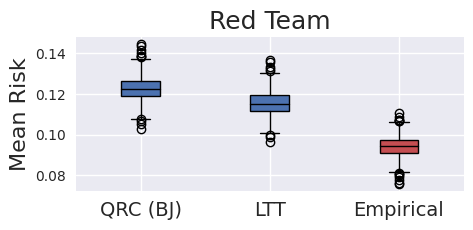

Experiment: full_chat_toxicity_mean_no_data_1000_full_results
Mean BJ
Mean KS
Mean RcpsWSR
Mean LttHB


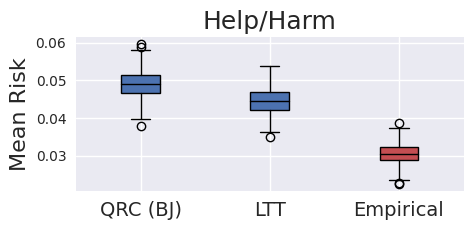

In [111]:
run_exp(
    dataset = "red_team_chat",
    loss_fn = "toxicity",
    measure = "Mean",
    single_prompt = True,
    # alpha = 0.125
)

run_exp(
    dataset = "full_chat",
    loss_fn = "toxicity",
    measure = "Mean",
    single_prompt = True,
    alpha = 0.05
)

Experiment: red_team_chat_toxicity_var_beta_0.85_no_data_1000
VaR LttHB
VaR DKW
VaR OrderStats
VaR KS
VaR BJ


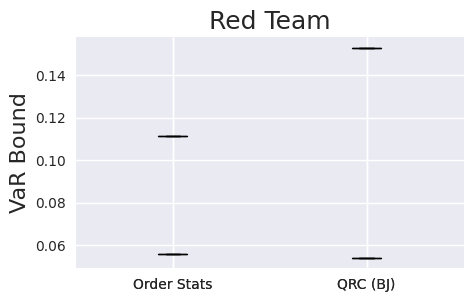

In [24]:
run_exp(
    dataset = "red_team_chat",
    loss_fn = "toxicity",
    measure = "VaR",
    beta_lo=0.85,
)

Experiment: red_team_chat_toxicity_mean_no_data_1000_full_results
Mean LttHB
Mean RcpsWSR
Mean KS
Mean BJ


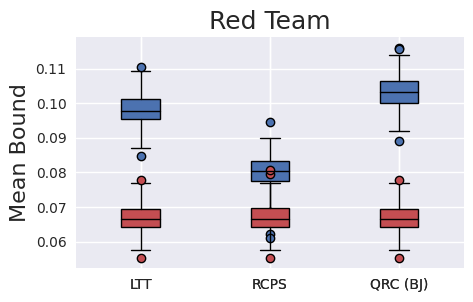

Experiment: full_chat_toxicity_mean_no_data_1000_full_results
Mean LttHB
Mean RcpsWSR
Mean KS
Mean BJ


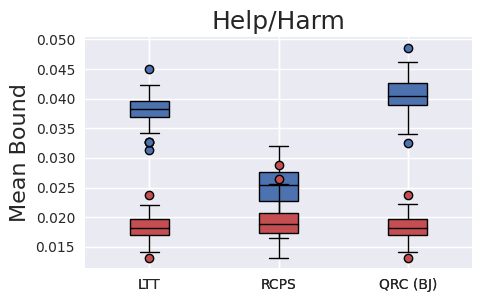

Experiment: xsum_bertscore_mean_no_data_1000_full_results
Mean LttHB
Mean RcpsWSR
Mean KS
Mean BJ


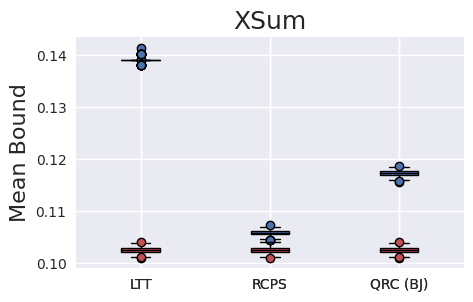

In [25]:
run_exp(
    dataset = "red_team_chat",
    loss_fn = "toxicity",
    measure = "Mean",
)

run_exp(
    dataset = "full_chat",
    loss_fn = "toxicity",
    measure = "Mean",
)

run_exp(
    dataset = "xsum",
    loss_fn = "bertscore",
    measure = "Mean",
)

Experiment: red_team_chat_toxicity_beta_lo_0.75_beta_hi_1.0_no_data_1000_grid_size_100_full_results
CVaR DKWBonferroni
CVaR OrderStatsBonferroni
CVaR KS
CVaR BJ
CVaR One-sided-BJ


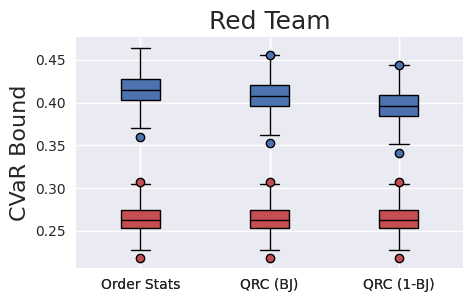

Experiment: full_chat_toxicity_beta_lo_0.75_beta_hi_1.0_no_data_1000_grid_size_100_full_results
CVaR DKWBonferroni
CVaR OrderStatsBonferroni
CVaR KS
CVaR BJ
CVaR One-sided-BJ


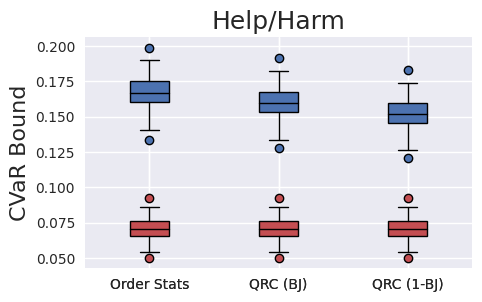

Experiment: xsum_bertscore_beta_lo_0.75_beta_hi_1.0_no_data_1000_grid_size_100_full_results
CVaR DKWBonferroni
CVaR OrderStatsBonferroni
CVaR KS
CVaR BJ
CVaR One-sided-BJ


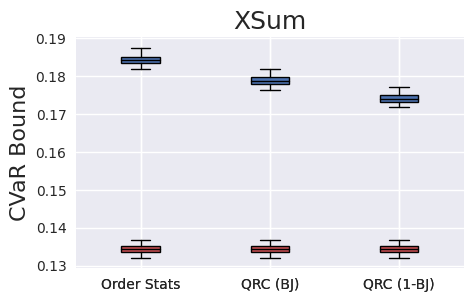

In [26]:
run_exp(
    dataset = "red_team_chat",
    loss_fn = "toxicity",
    measure = "CVaR",
    beta_lo = 0.75,
    beta_hi = 1.0,
)

run_exp(
    dataset = "full_chat",
    loss_fn = "toxicity",
    measure = "CVaR",
    beta_lo = 0.75,
    beta_hi = 1.0,
)

run_exp(
    dataset = "xsum",
    loss_fn = "bertscore",
    measure = "CVaR",
    beta_lo = 0.75,
    beta_hi = 1.0,
)

Experiment: red_team_chat_toxicity_beta_lo_0.75_beta_hi_0.95_no_data_1000_grid_size_100_full_results
VaR-Int DKWBonferroni
VaR-Int OrderStatsBonferroni
VaR-Int KS
VaR-Int BJ
VaR-Int One-sided-BJ
VaR-Int Two-sided-BJ


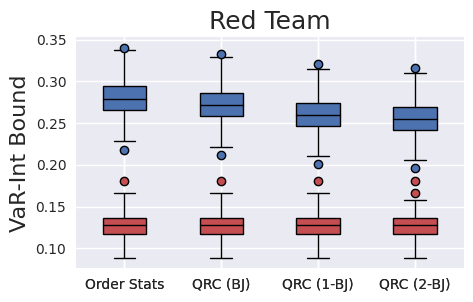

Experiment: full_chat_toxicity_beta_lo_0.75_beta_hi_0.95_no_data_1000_grid_size_100_full_results
VaR-Int DKWBonferroni
VaR-Int OrderStatsBonferroni
VaR-Int KS
VaR-Int BJ
VaR-Int One-sided-BJ
VaR-Int Two-sided-BJ


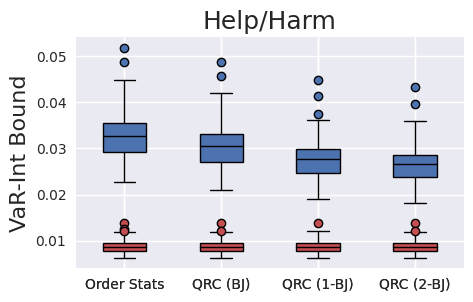

Experiment: xsum_bertscore_beta_lo_0.75_beta_hi_0.95_no_data_1000_grid_size_100_full_results
VaR-Int DKWBonferroni
VaR-Int OrderStatsBonferroni
VaR-Int KS
VaR-Int BJ
VaR-Int One-sided-BJ
VaR-Int Two-sided-BJ


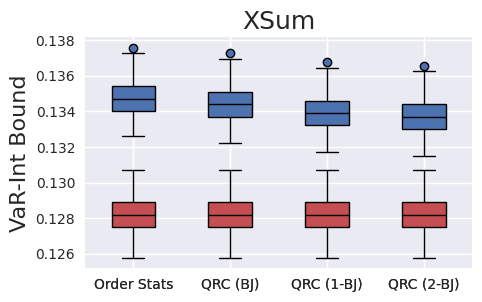

In [27]:
run_exp(
    dataset = "red_team_chat",
    loss_fn = "toxicity",
    measure = "VaR-Int",
    beta_lo = 0.75,
    beta_hi = 0.95,
)

run_exp(
    dataset = "full_chat",
    loss_fn = "toxicity",
    measure = "VaR-Int",
    beta_lo = 0.75,
    beta_hi = 0.95,
)

run_exp(
    dataset = "xsum",
    loss_fn = "bertscore",
    measure = "VaR-Int",
    beta_lo = 0.75,
    beta_hi = 0.95,
)